# Introduction

This notebook will dimonstrate the differences between BF16 vs FP8 as well as TP1 vs TP2

# Environment checks

In [3]:
!python3 --version

Python 3.12.3


In [4]:
!nvidia-smi

Tue Nov 11 15:09:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0             79W /  700W |       0MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Installing Prerequesists

In [5]:
!apt update -y && apt install pipx -y

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  Packages [1004 kB]
Get:3 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]     
Get:4 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]                
Get:5 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1170 kB]
Get:6 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [2709 kB]
Get:7 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:8 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [33.1 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1643 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]     
Get:11 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble/main

In [6]:
!pipx install vllm==0.11.0 aiperf==0.2.0 lm-eval[api]==0.4.9.1

  installed package vllm 0.11.0, installed using Python 3.12.3
  These apps are now globally available
    - vllm
⚠️  Note: '/root/.local/bin' is not on your PATH environment variable. These
    apps will not be globally accessible until your PATH is updated. Run `pipx
    ensurepath` to automatically add it, or manually modify your PATH in your
    shell's config file (i.e. ~/.bashrc).
done! ✨ 🌟 ✨
  installed package aiperf 0.2.0, installed using Python 3.12.3
  These apps are now globally available
    - aiperf
⚠️  Note: '/root/.local/bin' is not on your PATH environment variable. These
    apps will not be globally accessible until your PATH is updated. Run `pipx
    ensurepath` to automatically add it, or manually modify your PATH in your
    shell's config file (i.e. ~/.bashrc).
done! ✨ 🌟 ✨
  installed package lm-eval 0.4.9.1, installed using Python 3.12.3
  These apps are now globally available
    - lm-eval
    - lm_eval
⚠️  Note: '/root/.local/bin' is not on your PATH environme

In [7]:
import os
os.environ["PATH"] = os.path.expanduser("~/.local/bin") + ":" + os.environ["PATH"]

In [8]:
!git clone https://github.com/NVIDIA/TensorRT-Model-Optimizer.git --depth 1 --branch 0.37.0

Cloning into 'TensorRT-Model-Optimizer'...
remote: Enumerating objects: 921, done.
remote: Counting objects: 100% (921/921), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 921 (delta 134), reused 375 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (921/921), 11.30 MiB | 30.76 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Note: switching to 'df0882a63c39a001a1be384b680166a41259045c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [9]:
!pip3 install \
-r ./TensorRT-Model-Optimizer/examples/llm_ptq/requirements.txt \
-e "./TensorRT-Model-Optimizer[hf]" \
seaborn

Obtaining file:///workspace/main/TensorRT-Model-Optimizer
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached rouge_score-0.1.2-py3-none-any.whl
  Preparing metadata (setup.py) ... done
  Using cached zstandard-0.25.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 122.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached zstandard-0.25.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (5.5 MB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Building editable for nvidia-modelopt (pyproject.toml) ... done
  Created whe

# Environment Variables

Feel free to upload your own model or download a different one

In [10]:
os.environ["MODEL_PATH"] = "/workspace/main/Yi-34B"
os.environ["MODEL_NAME"] = "Yi-34B"
os.environ["ROOT_SAVE_PATH"] = "/workspace/main"
os.environ["CONCURRENCY_LIST"] = "1 10 50 100 150"

In [11]:
!hf download 01-ai/Yi-34B --local-dir $MODEL_PATH

Fetching 26 files:   0%|                                 | 0/26 [00:00<?, ?it/s]Downloading 'README.md' to '/workspace/main/Yi-34B/.cache/huggingface/download/Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.2395a3bc02655e084849e9e0a9e2d8462ed0acc9.incomplete'

README.md: 0.00B [00:00, ?B/s]

Yi.svg: 100%|██████████████████████████████████| 980/980 [00:00<00:00, 6.83MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/Yi.svg


model-00001-of-00007.safetensors:   0%|             | 0.00/9.98G [00:00<?, ?B/s]Downloading 'generation_config.json' to '/workspace/main/Yi-34B/.cache/huggingface/download/3EVKVggOldJcKSsGjSdoUCN1AyQ=.2c6a963442c6f58367b5518912e1cd8dfd486d3f.incomplete'
README.md: 87.9kB [00:00, 8.81MB/s]
Download complete. Moving file to /workspace/main/Yi-34B/README.md

LICENSE: 0.00B [00:00, ?B/s]


LICENSE: 11.3kB [00:00, 4.24MB/s]                     | 0.00/605 [00:00<?, ?B/s]
Download complete. Moving file to /workspace/main/Yi-34B/LICENSE
config.json: 100%|██████████████████████████

# Quantize to FP8

In [12]:
!./TensorRT-Model-Optimizer/examples/llm_ptq/scripts/huggingface_example.sh --model $MODEL_PATH --quant fp8

model: /workspace/main/Yi-34B
quant: fp8
tp (TensorRT-LLM Checkpoint only): 1
pp (TensorRT-LLM Checkpoint only): 1
sparsity: dense
awq_block_size: 
calib: 512
calib_batch_size: 0
auto_quantize_bits: 
input: 
output: 1024
batch: 2
tasks: quant
lm_eval_tasks: mmlu,gsm8k
lm_eval_limit: 
simple_eval_tasks: mmlu
num_sample: 
use_seq_device_map: false
gpu_max_mem_percentage: 
kv_cache_free_gpu_memory_fraction: 0.8
low_memory_mode: 
calib_dataset: 
+ echo '********** unset all SLURM_, PMI_, PMIX_ Variables **********'
********** unset all SLURM_, PMI_, PMIX_ Variables **********
++ grep '^SLURM_'
++ env
++ cut -d= -f 1
++ env
++ grep '^PMI_'
++ cut -d= -f 1
++ env
++ grep '^PMIX_'
++ cut -d= -f 1
+ '[' -z /workspace/main/Yi-34B ']'
+ '[' dense = dense ']'
+ ENABLE_SPARSITY=false
+ case $SPARSITY_FMT in
+ IFS=,
+ for qformat in $QFORMAT
+ case $qformat in
+ IFS=' '
+++ readlink -f ./TensorRT-Model-Optimizer/examples/llm_ptq/scripts/huggingface_example.sh
++ dirname /workspace/main/TensorRT-Mod

# Serve vLLM for FP8-TP1

In [13]:
!touch /tmp/vllm.log

In [14]:
!pkill vllm

In [15]:
!sleep 3

In [16]:
%%bash --bg

vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp1 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [17]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 15:26:07 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=5591) INFO 11-11 15:26:10 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=5591) INFO 11-11 15:26:10 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp1'], 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=5591) INFO 11-11 15:26:15 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=5591) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=5591) INFO 11-11 15:26:15 [model.py:1510] Using max model len 4096
(APIServer pid=5591) INFO 11-11 15:26:15 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer pid=5591) INFO 11-11 15:26:15 [arg

In [18]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:27:44 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP1

In [19]:
import os

os.environ["AIPERF_COMMAND"] = "--ui-type simple --tokenizer {MODEL_PATH} \
--url 127.0.0.1:8000 --streaming --endpoint-type completions \
--output-tokens-mean 256 --output-tokens-stddev 0 \
--synthetic-input-tokens-mean 256 --synthetic-input-tokens-stddev 0 \
--benchmark-duration 20 --extra-inputs ignore_eos:true".format(MODEL_PATH=os.environ["MODEL_PATH"])

In [20]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp1 --concurrency $c; \
done

15:27:45.471952 INFO     Starting AIPerf System                 ]8;id=151005;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=995779;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:27:46.555418 INFO     Record metrics    ]8;id=255598;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=688842;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         fp8-tp1-openai-co                                      
                         mpletions-concurr         

In [21]:
!ls artifacts

Yi-34B-fp8-tp1-openai-completions-concurrency1
Yi-34B-fp8-tp1-openai-completions-concurrency10
Yi-34B-fp8-tp1-openai-completions-concurrency100
Yi-34B-fp8-tp1-openai-completions-concurrency150
Yi-34B-fp8-tp1-openai-completions-concurrency50


In [23]:
!lm-eval --model local-completions --tasks mmlu_high_school_world_history \
--model_args model=${MODEL_NAME}-fp8-tp1,tokenizer=${MODEL_PATH},base_url=http://127.0.0.1:8000/v1/completions,num_concurrent=16,max_retries=3,tokenized_requests=False \
--output_path ./lm-eval/${MODEL_NAME}-fp8.json

2025-11-11:15:30:14 INFO     [__main__:446] Selected Tasks: ['mmlu_high_school_world_history']
2025-11-11:15:30:14 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-11-11:15:30:14 INFO     [evaluator:240] Initializing local-completions model, with arguments: {'model': 'Yi-34B-fp8-tp1', 'tokenizer': '/workspace/main/Yi-34B', 'base_url':
        'http://127.0.0.1:8000/v1/completions', 'num_concurrent': 16, 'max_retries': 3, 'tokenized_requests': False}
2025-11-11:15:30:14 INFO     [models.api_models:170] Using max length 2048 - 1
2025-11-11:15:30:14 INFO     [models.api_models:189] Using tokenizer huggingface
Traceback (most recent call last):
  File "/root/.local/bin/lm-eval", line 7, in <module>
    sys.exit(cli_evaluate())
             ^^^^^^^^^^^^^^
  File "/root/.local/share/pipx/venvs/lm-eval/lib/python3.12/site-packages/lm_eval/__main__.py", line 455, in cli_evaluate
    res

# Serve vLLM for BF16-TP1

In [24]:
!pkill vllm

In [25]:
!sleep 5

In [26]:
%%bash --bg

~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp1 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [27]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 15:30:24 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=16250) INFO 11-11 15:30:26 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=16250) INFO 11-11 15:30:26 [utils.py:233] non-default args: {'model_tag': '/workspace/main/Yi-34B', 'model': '/workspace/main/Yi-34B', 'served_model_name': ['Yi-34B-bf16-tp1'], 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=16250) INFO 11-11 15:30:26 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=16250) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=16250) INFO 11-11 15:30:26 [model.py:1510] Using max model len 4096
(APIServer pid=16250) INFO 11-11 15:30:27 [arg_utils.py:1293] Defaulting to mp-based distributed executor backend for async scheduling.
(APIServer pid=16250) INFO 11-11 15:30:27 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 11-11 15:30:29 [__init__.py:216] Automatically detected platform 

In [28]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:31:42 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP1

In [29]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp1 --concurrency $c; \
done

15:31:43.976389 INFO     Starting AIPerf System                 ]8;id=617018;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=905481;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:31:44.814841 INFO     Record metrics    ]8;id=600852;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=256776;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         bf16-tp1-openai-c                                      
                         ompletions-concur         

In [30]:
!lm-eval --model local-completions --tasks mmlu_high_school_world_history \
--model_args model=${MODEL_NAME}-bf16-tp1,tokenizer=${MODEL_PATH},base_url=http://127.0.0.1:8000/v1/completions,num_concurrent=16,max_retries=3,tokenized_requests=False \
--output_path ./lm-eval/${MODEL_NAME}.json

2025-11-11:15:34:03 INFO     [__main__:446] Selected Tasks: ['mmlu_high_school_world_history']
2025-11-11:15:34:03 INFO     [evaluator:202] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-11-11:15:34:03 INFO     [evaluator:240] Initializing local-completions model, with arguments: {'model': 'Yi-34B-bf16-tp1', 'tokenizer': '/workspace/main/Yi-34B', 'base_url':
        'http://127.0.0.1:8000/v1/completions', 'num_concurrent': 16, 'max_retries': 3, 'tokenized_requests': False}
2025-11-11:15:34:03 INFO     [models.api_models:170] Using max length 2048 - 1
2025-11-11:15:34:03 INFO     [models.api_models:189] Using tokenizer huggingface
README.md: 53.2kB [00:00, 174MB/s]
dataset_infos.json: 138kB [00:00, 433MB/s]
high_school_world_history/test-00000-of-(…): 100%|█| 202k/202k [00:00<00:00, 526
high_school_world_history/validation-000(…): 100%|█| 38.5k/38.5k [00:00<00:00, 1
high_school_world_history/dev-00000-

# Compare FP8 and BF16 on MMLU Accuracy

In [31]:
!cat ./lm-eval/* | jq '.model_name, .results'

"Yi-34B-bf16-tp1"
{
  "mmlu_high_school_world_history": {
    "alias": "high_school_world_history",
    "acc,none": 0.8860759493670886,
    "acc_stderr,none": 0.020681745135884527
  }
}


# Serve vLLM for FP8-TP2

In [32]:
!pkill vllm

In [33]:
!sleep 5

In [34]:
%%bash --bg
~/.local/bin/vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp2 \
    --tensor-parallel-size 2 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [35]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 15:35:11 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=26689) INFO 11-11 15:35:14 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=26689) INFO 11-11 15:35:14 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp2'], 'tensor_parallel_size': 2, 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=26689) INFO 11-11 15:35:14 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=26689) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=26689) INFO 11-11 15:35:14 [model.py:1510] Using max model len 4096
(APIServer pid=26689) INFO 11-11 15:35:14 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer p

In [36]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:36:42 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP2

In [37]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp2 --concurrency $c; \
done

15:36:43.764691 INFO     Starting AIPerf System                 ]8;id=518793;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=681164;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:36:44.602448 INFO     Record metrics    ]8;id=662923;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=452390;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         fp8-tp2-openai-co                                      
                         mpletions-concurr         

# Serve vLLM for BF16-TP2

In [38]:
!pkill vllm

In [39]:
!sleep 5

In [40]:
%%bash --bg

~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp2 \
    --tensor-parallel-size 2 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [41]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

(APIServer pid=26689) INFO:     127.0.0.1:36998 - "POST /v1/completions HTTP/1.1" 200 OK
(APIServer pid=26689) INFO 11-11 15:38:48 [launcher.py:99] Shutting down FastAPI HTTP server.
(Worker_TP0 pid=26966) INFO 11-11 15:38:48 [multiproc_executor.py:558] Parent process exited, terminating worker
(Worker_TP0 pid=26966) INFO 11-11 15:38:48 [multiproc_executor.py:599] WorkerProc shutting down.
(Worker_TP1 pid=26967) INFO 11-11 15:38:48 [multiproc_executor.py:558] Parent process exited, terminating worker
(Worker_TP1 pid=26967) INFO 11-11 15:38:48 [multiproc_executor.py:599] WorkerProc shutting down.
(APIServer pid=26689) INFO:     Shutting down
(APIServer pid=26689) INFO 11-11 15:38:52 [loggers.py:127] Engine 000: Avg prompt throughput: 3416.9 tokens/s, Avg generation throughput: 3501.1 tokens/s, Running: 0 reqs, Waiting: 0 reqs, GPU KV cache usage: 0.0%, Prefix cache hit rate: 0.0%
(APIServer pid=26689) INFO:     Waiting for application shutdown.
(APIServer pid=26689) INFO:     Applicatio

In [42]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:40:12 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP2

In [43]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp2 --concurrency $c; \
done

15:40:14.317884 INFO     Starting AIPerf System                 ]8;id=769161;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=638318;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:40:15.132788 INFO     Record metrics    ]8;id=881030;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=387255;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         bf16-tp2-openai-c                                      
                         ompletions-concur         

# Serve vLLM for FP8-TP8

In [44]:
!pkill vllm

In [45]:
!sleep 5

In [46]:
%%bash --bg
~/.local/bin/vllm serve ${ROOT_SAVE_PATH}/saved_models_${MODEL_NAME}_fp8 \
    --served_model_name ${MODEL_NAME}-fp8-tp8 \
    --tensor-parallel-size 8 \
    --kv-cache-dtype fp8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [47]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 15:42:26 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=47850) INFO 11-11 15:42:28 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=47850) INFO 11-11 15:42:28 [utils.py:233] non-default args: {'model_tag': '/workspace/main/saved_models_Yi-34B_fp8', 'model': '/workspace/main/saved_models_Yi-34B_fp8', 'served_model_name': ['Yi-34B-fp8-tp8'], 'tensor_parallel_size': 8, 'kv_cache_dtype': 'fp8', 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=47850) INFO 11-11 15:42:28 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=47850) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=47850) INFO 11-11 15:42:28 [model.py:1510] Using max model len 4096
(APIServer pid=47850) INFO 11-11 15:42:28 [cache.py:180] Using fp8 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. Meanwhile, it may cause accuracy drop without a proper scaling factor.
(APIServer p

In [48]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:44:06 GMT
server: uvicorn
content-length: 0



## Benchmark FP8-TP8

In [49]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-fp8-tp8 --concurrency $c; \
done

15:44:07.736357 INFO     Starting AIPerf System                 ]8;id=116956;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=692533;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:44:08.544347 INFO     Record metrics    ]8;id=344973;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=845758;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         fp8-tp8-openai-co                                      
                         mpletions-concurr         

# Serve vLLM for BF16-TP8

In [50]:
!pkill vllm

In [51]:
!sleep 5

In [52]:
%%bash --bg
~/.local/bin/vllm serve ${MODEL_PATH} \
    --served_model_name ${MODEL_NAME}-bf16-tp8 \
    --tensor-parallel-size 8 \
    --async-scheduling \
    --no-enable-prefix-caching &> /tmp/vllm.log

In [53]:
!tail -f /tmp/vllm.log | sed '/Application startup complete./q'

INFO 11-11 15:46:19 [__init__.py:216] Automatically detected platform cuda.
(APIServer pid=60469) INFO 11-11 15:46:21 [api_server.py:1839] vLLM API server version 0.11.0
(APIServer pid=60469) INFO 11-11 15:46:21 [utils.py:233] non-default args: {'model_tag': '/workspace/main/Yi-34B', 'model': '/workspace/main/Yi-34B', 'served_model_name': ['Yi-34B-bf16-tp8'], 'tensor_parallel_size': 8, 'enable_prefix_caching': False, 'async_scheduling': True}
(APIServer pid=60469) INFO 11-11 15:46:21 [model.py:547] Resolved architecture: LlamaForCausalLM
(APIServer pid=60469) `torch_dtype` is deprecated! Use `dtype` instead!
(APIServer pid=60469) INFO 11-11 15:46:21 [model.py:1510] Using max model len 4096
(APIServer pid=60469) INFO 11-11 15:46:22 [arg_utils.py:1293] Defaulting to mp-based distributed executor backend for async scheduling.
(APIServer pid=60469) INFO 11-11 15:46:22 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 11-11 15:46:24 [__init__.py:216] Autom

In [54]:
!curl -X GET -I http://127.0.0.1:8000/health

HTTP/1.1 200 OK
date: Tue, 11 Nov 2025 15:47:43 GMT
server: uvicorn
content-length: 0



## Benchmark BF16-TP8

In [55]:
!for c in ${CONCURRENCY_LIST}; do \
aiperf profile  ${AIPERF_COMMAND} -m ${MODEL_NAME}-bf16-tp8 --concurrency $c; \
done

15:47:44.528738 INFO     Starting AIPerf System                 ]8;id=954891;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py\cli_runner.py]8;;\:]8;id=701087;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/cli_runner.py#75\75]8;;\
15:47:45.342467 INFO     Record metrics    ]8;id=651908;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py\record_export_results_processor.py]8;;\:]8;id=834411;file:///root/.local/share/pipx/venvs/aiperf/lib/python3.12/site-packages/aiperf/post_processors/record_export_results_processor.py#49\49]8;;\
                         export enabled:                                        
                         artifacts/Yi-34B-                                      
                         bf16-tp8-openai-c                                      
                         ompletions-concur         

# Plot Benchmarking Data

In [56]:
!ls artifacts

Yi-34B-bf16-tp1-openai-completions-concurrency1
Yi-34B-bf16-tp1-openai-completions-concurrency10
Yi-34B-bf16-tp1-openai-completions-concurrency100
Yi-34B-bf16-tp1-openai-completions-concurrency150
Yi-34B-bf16-tp1-openai-completions-concurrency50
Yi-34B-bf16-tp2-openai-completions-concurrency1
Yi-34B-bf16-tp2-openai-completions-concurrency10
Yi-34B-bf16-tp2-openai-completions-concurrency100
Yi-34B-bf16-tp2-openai-completions-concurrency150
Yi-34B-bf16-tp2-openai-completions-concurrency50
Yi-34B-bf16-tp8-openai-completions-concurrency1
Yi-34B-bf16-tp8-openai-completions-concurrency10
Yi-34B-bf16-tp8-openai-completions-concurrency100
Yi-34B-bf16-tp8-openai-completions-concurrency150
Yi-34B-bf16-tp8-openai-completions-concurrency50
Yi-34B-fp8-tp1-openai-completions-concurrency1
Yi-34B-fp8-tp1-openai-completions-concurrency10
Yi-34B-fp8-tp1-openai-completions-concurrency100
Yi-34B-fp8-tp1-openai-completions-concurrency150
Yi-34B-fp8-tp1-openai-completions-concurrency50
Yi-34B-fp8-tp2-openai

In [57]:
import pandas as pd 
import seaborn as sns

In [58]:
def normalize_df_benchmark(df):
    df.melt(id_vars=['Metric'], var_name='stat', value_name='value').pivot_table(index=None, columns=['Metric', 'stat'], values='value', aggfunc='first')
    normalized = (
        df.melt(id_vars=['Metric'], var_name='stat', value_name='value')
          .pivot_table(index=None, columns=['Metric', 'stat'], values='value', aggfunc='first')
    )
    
    # Flatten the MultiIndex into single-level columns like Metric_stat
    normalized.columns = [f"{metric.strip().replace(' ', '_')}_{stat}" for metric, stat in normalized.columns]
    normalized = normalized.reset_index(drop=True)
    normalized = normalized.apply(pd.to_numeric, errors='coerce')
    
    return normalized

In [75]:
profiles_dirs = sorted(os.listdir("artifacts"))
df_benchmark_list = []
for pdir in profiles_dirs:
    model_name, concurrency = pdir.split("-openai-completions-concurrency")
    concurrency = int(concurrency)
    _, dtype, tensor_parallelism = model_name.rsplit("-", 2)
    tensor_parallelism = int(tensor_parallelism.strip("tp"))

    df_benchmark_pdir = pd.read_csv("artifacts/" + pdir +"/profile_export_aiperf.csv", on_bad_lines='skip')
    df_benchmark_pdir = normalize_df_benchmark(df_benchmark_pdir)
    df_benchmark_pdir = df_benchmark_pdir.assign(model=model_name, dtype=dtype, tensor_parallelism=tensor_parallelism)

    throughput_columns = "Output_Token_Throughput_(tokens/sec)_avg"
    df_benchmark_pdir[throughput_columns] = df_benchmark_pdir[throughput_columns] / df_benchmark_pdir["tensor_parallelism"]
    
    df_benchmark_list.append(df_benchmark_pdir)

df_benchmark = pd.concat(df_benchmark_list, ignore_index=True)

# Renaming columns
df_benchmark["TTFT (ms)"] = df_benchmark["Time_to_First_Token_(ms)_avg"]
df_benchmark["ITL (ms)"] = df_benchmark["Inter_Token_Latency_(ms)_avg"]
df_benchmark["TPS per User"] = df_benchmark["Output_Token_Throughput_Per_User_(tokens/sec/user)_avg"]
df_benchmark["TPS per GPU"] = df_benchmark["Output_Token_Throughput_(tokens/sec)_avg"]

In [44]:
profile_export_aiperf_path = "artifacts/{}-openai-completions-concurrency{}/profile_export_aiperf.csv"

df_benchmark_con = []
df_tp2_benchmark_con = []
df_fp8_benchmark_con = []
df_fp8_tp2_benchmark_con = []
concurrency_list = list(map(int, os.environ["CONCURRENCY_LIST"].split()))
for c in concurrency_list:
    df_benchmark_con.append(pd.read_csv(profile_export_aiperf_path.format(os.environ["MODEL_NAME"], str(c)), on_bad_lines='skip'))
    df_tp2_benchmark_con.append(pd.read_csv(profile_export_aiperf_path.format(os.environ["MODEL_NAME"] + "-tp2", str(c)), on_bad_lines='skip'))
    df_fp8_benchmark_con.append(pd.read_csv(profile_export_aiperf_path.format(os.environ["MODEL_NAME"] + "-fp8", str(c)), on_bad_lines='skip'))
    df_fp8_tp2_benchmark_con.append(pd.read_csv(profile_export_aiperf_path.format(os.environ["MODEL_NAME"] + "-fp8-tp2", str(c)),on_bad_lines='skip'))

In [45]:
df_benchmark_con = list(map(normalize_df_benchmark, df_benchmark_con))
df_tp2_benchmark_con = list(map(normalize_df_benchmark, df_tp2_benchmark_con))
df_fp8_benchmark_con = list(map(normalize_df_benchmark, df_fp8_benchmark_con))
df_fp8_tp2_benchmark_con = list(map(normalize_df_benchmark, df_fp8_tp2_benchmark_con))

In [46]:
df_benchmark_con = [i.assign(concurrency=c) for i,c in zip(df_benchmark_con, concurrency_list)]
df_tp2_benchmark_con = [i.assign(concurrency=c) for i,c in zip(df_tp2_benchmark_con, concurrency_list)]
df_fp8_benchmark_con = [i.assign(concurrency=c) for i,c in zip(df_fp8_benchmark_con, concurrency_list)]
df_fp8_tp2_benchmark_con = [i.assign(concurrency=c) for i,c in zip(df_fp8_tp2_benchmark_con, concurrency_list)]

In [47]:
df_benchmark = pd.concat(df_benchmark_con)
df_tp2_benchmark = pd.concat(df_tp2_benchmark_con)
df_fp8_benchmark = pd.concat(df_fp8_benchmark_con)
df_fp8_tp2_benchmark = pd.concat(df_fp8_tp2_benchmark_con)


In [48]:
# In here we need to normalize per GPU, since TP2 uses two GPUs then the throughput will be divided by 2
throughput_columns = "Output_Token_Throughput_(tokens/sec)_avg"
df_tp2_benchmark[throughput_columns] = df_tp2_benchmark[throughput_columns] / 2
df_fp8_tp2_benchmark[throughput_columns] = df_fp8_tp2_benchmark[throughput_columns] / 2


In [49]:
df_benchmark = pd.concat([
    df_benchmark.assign(model=os.environ["MODEL_NAME"]),
    df_tp2_benchmark.assign(model=os.environ["MODEL_NAME"]+"-tp2"),
    df_fp8_benchmark.assign(model=os.environ["MODEL_NAME"]+"-fp8"),
    df_fp8_tp2_benchmark.assign(model=os.environ["MODEL_NAME"]+"-fp8-tp2"),
], ignore_index=True)
df_benchmark

,Benchmark_Duration_(sec)_avg,Input_Sequence_Length_(tokens)_avg,Input_Sequence_Length_(tokens)_max,Input_Sequence_Length_(tokens)_min,Input_Sequence_Length_(tokens)_p1,Input_Sequence_Length_(tokens)_p10,Input_Sequence_Length_(tokens)_p25,Input_Sequence_Length_(tokens)_p5,Input_Sequence_Length_(tokens)_p50,Input_Sequence_Length_(tokens)_p75,...,Time_to_Second_Token_(ms)_p75,Time_to_Second_Token_(ms)_p90,Time_to_Second_Token_(ms)_p95,Time_to_Second_Token_(ms)_p99,Time_to_Second_Token_(ms)_std,Total_Input_Sequence_Length_(tokens)_avg,Total_Output_Sequence_Length_(tokens)_avg,Total_Output_Tokens_(tokens)_avg,concurrency,model
0,19.44,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,19.07,19.30,19.38,19.44,0.29,1024.0,1023.0,1023.0,1,Yi-34B
1,21.09,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,19.56,21.13,21.14,21.17,0.94,10240.0,10224.0,10224.0,10,Yi-34B
2,20.58,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,442.00,443.31,443.34,443.42,204.26,38400.0,38332.0,38332.0,50,Yi-34B
3,27.33,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,878.23,881.97,882.48,882.73,369.57,76800.0,76691.0,76691.0,100,Yi-34B
4,23.03,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,881.35,882.93,883.64,883.89,304.62,76800.0,76702.0,76702.0,150,Yi-34B
5,18.15,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,11.84,12.25,12.42,12.54,0.43,1536.0,1534.0,1534.0,1,Yi-34B-tp2
6,23.18,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,12.31,14.28,14.31,14.35,0.80,17920.0,17893.0,17893.0,10,Yi-34B-tp2
7,20.50,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,242.26,245.06,448.29,496.39,129.07,64000.0,63896.0,63896.0,50,Yi-34B-tp2
8,21.70,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,493.34,501.99,526.80,526.91,209.02,102400.0,102238.0,102238.0,100,Yi-34B-tp2
9,20.68,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,256.0,...,497.11,503.98,507.94,508.13,211.49,115200.0,115025.0,115025.0,150,Yi-34B-tp2


In [66]:
list(df_benchmark.columns)

['Benchmark_Duration_(sec)_avg',
 'Input_Sequence_Length_(tokens)_avg',
 'Input_Sequence_Length_(tokens)_max',
 'Input_Sequence_Length_(tokens)_min',
 'Input_Sequence_Length_(tokens)_p1',
 'Input_Sequence_Length_(tokens)_p10',
 'Input_Sequence_Length_(tokens)_p25',
 'Input_Sequence_Length_(tokens)_p5',
 'Input_Sequence_Length_(tokens)_p50',
 'Input_Sequence_Length_(tokens)_p75',
 'Input_Sequence_Length_(tokens)_p90',
 'Input_Sequence_Length_(tokens)_p95',
 'Input_Sequence_Length_(tokens)_p99',
 'Input_Sequence_Length_(tokens)_std',
 'Inter_Chunk_Latency_(ms)_avg',
 'Inter_Chunk_Latency_(ms)_max',
 'Inter_Chunk_Latency_(ms)_min',
 'Inter_Chunk_Latency_(ms)_p1',
 'Inter_Chunk_Latency_(ms)_p10',
 'Inter_Chunk_Latency_(ms)_p25',
 'Inter_Chunk_Latency_(ms)_p5',
 'Inter_Chunk_Latency_(ms)_p50',
 'Inter_Chunk_Latency_(ms)_p75',
 'Inter_Chunk_Latency_(ms)_p90',
 'Inter_Chunk_Latency_(ms)_p95',
 'Inter_Chunk_Latency_(ms)_p99',
 'Inter_Chunk_Latency_(ms)_std',
 'Inter_Token_Latency_(ms)_avg',
 '

<Axes: xlabel='TTFT (ms)', ylabel='TPS per GPU'>

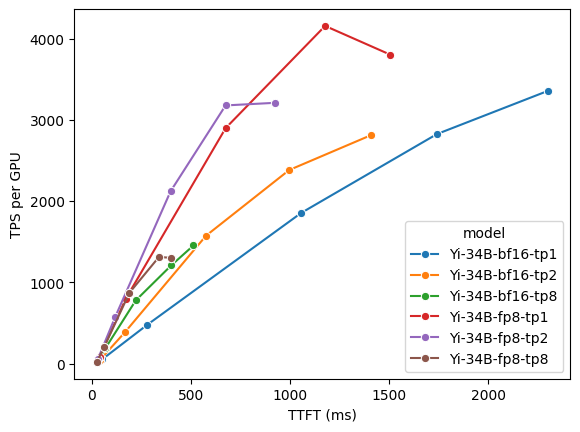

In [76]:
sns.lineplot(data=df_benchmark, x="TTFT (ms)", y="TPS per GPU", hue="model", marker="o")

<Axes: xlabel='ITL (ms)', ylabel='TPS per GPU'>

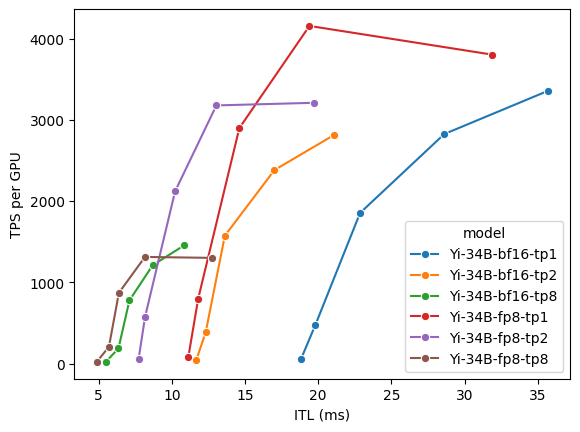

In [77]:
sns.lineplot(data=df_benchmark, x="ITL (ms)", y="TPS per GPU", hue="model", marker="o")

<Axes: xlabel='TPS per User', ylabel='TPS per GPU'>

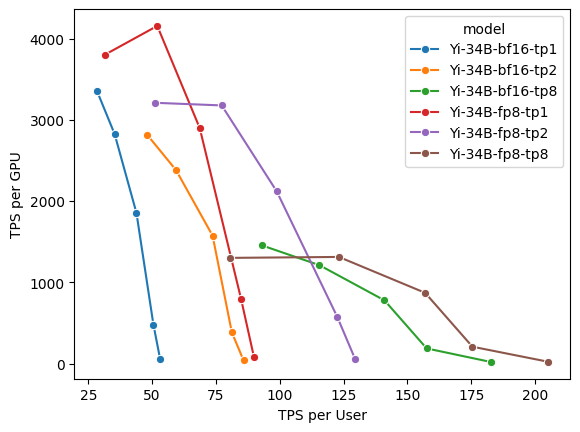

In [78]:
sns.lineplot(data=df_benchmark, x="TPS per User", y="TPS per GPU", hue="model", marker="o")